# Computing cell mask

In [1]:
from __future__ import division

## Exercises 1 - read images

In [2]:
# import imread from skimage
# read fitc, tritc, hoechst, smoothed_image and composite saved before
# convert image as float
from skimage.io import imread
from skimage.util import img_as_float

fitc = imread(r'fitc.jpeg')
tritc = imread(r'tritc.jpeg')
hoechst = imread(r'hoechst.jpeg')
smoothed_image = imread(r'smoothed_image.jpeg')
composite = imread(r'composite.jpeg')

fitc = img_as_float(fitc)
tritc = img_as_float(tritc)
hoechst = img_as_float(hoechst)
smoothed_image = img_as_float(smoothed_image)
composite = img_as_float(composite)

#### re-calculate the  mask of the nuclei seen previously in nuclei_analysis notebook

In [3]:
import numpy
from skimage.filters import threshold_otsu

nmask = numpy.zeros(smoothed_image.shape, dtype = bool)
nmask[smoothed_image > threshold_otsu(smoothed_image)] = 1
from skimage.morphology import diamond
se = diamond(1)

from skimage.morphology import closing
from skimage.morphology import opening
from scipy.ndimage import binary_fill_holes 

nmask = opening(closing(nmask, se),se)
nmask = binary_fill_holes(nmask)

## Exercises 2 - Adjust Brightness and Contrast

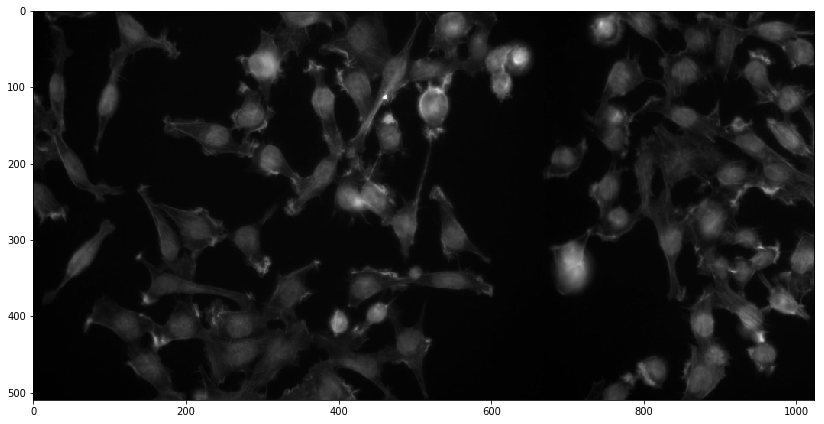

In [4]:
# Before doing a segmentation of the the cell image, try to increase the brigtness and the contrast of the image. 
# Note: Play with mathematical operator
# operator '+' or '-' for the brigthness
# operator '*' for contrast

ntritc = tritc * 2.82 - 0.17
nfitc = fitc * 5.03 - 0.35
nhoechst = hoechst * 2.99 - 0.15

# Visualize the result after having created a composite image using plt.imshow and plt.show
import matplotlib.pyplot as plt

mix = nfitc+ntritc+nhoechst
plt.figure(figsize=(14,14))
plt.imshow(mix, cmap = 'gray')
plt.show()

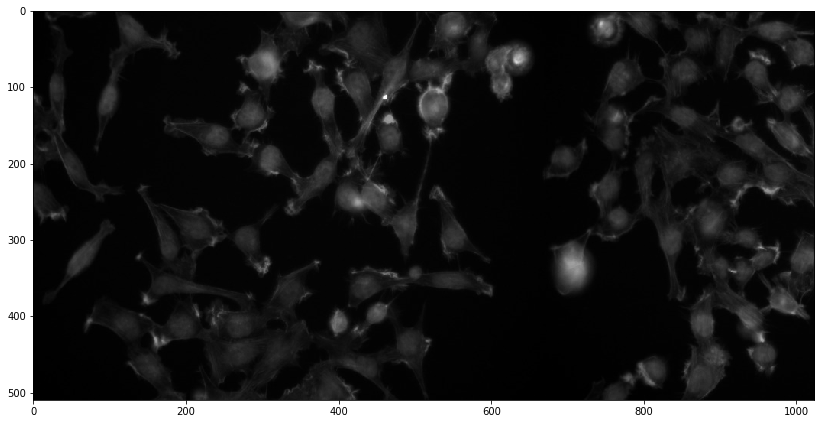

In [5]:
# Improve the brightness of the image by playing with the gamma.
# Use the operator ^ (** in python) to apply a gamma correction
mix_2 = (nfitc**2+ntritc**2+nhoechst**2)**0.5

# Visualize the result
plt.figure(figsize=(14,14))
plt.imshow(mix_2, cmap = 'gray')
plt.show()

## 2d convolution filter

Linear filtering is useful to perform low-pass filtering (to blur images, remove noise...) and high-pass filtering (to detect edges, sharpen images).

## Exercises 3 - Apply a convolution filter

In [6]:
# Create a cross-shaped structuring element and asign it to a new variable.
# Structuring elements are small binary images that indicate which pixels 
# should be considered as the 'neighborhood' of the central pixel.
# create a matrix with 3 columns and 3 rows as below
# 0 1 0
# 1 2 1
# 0 1 0
# then divide all values by 6 to obtain a float type matrix. Use the function matrix from numpy. 
import numpy as np
se = np.matrix([[0,1,0],[1,2,1],[0,1,0]], dtype='float')/6

# Import signal from scipy to get the convolve2d function. Execute the 2d convolution filter on the image. 
# Read the documentation to get more details on the parameters of the functio
from scipy import signal

cmask = signal.convolve2d(mix_2, se, boundary="wrap", mode="same") > 0.12

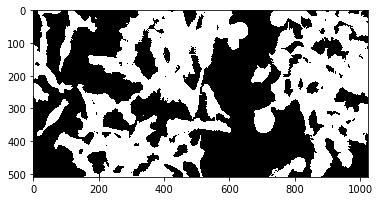

In [7]:
#(iii) display the result
plt.imshow(cmask,interpolation='none',cmap='gray')
plt.show()

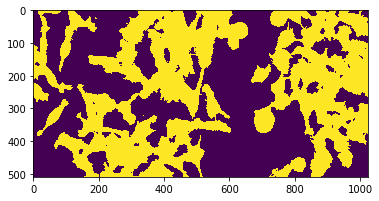

In [8]:
# Create a diamond-shaped structuring element and asign it to a new variable.
# Structuring elements are small binary images that indicate which pixels 
# should be considered as the 'neighborhood' of the central pixel.
# You can use skimage.morphology.diamond to create diamond-shaped structuring element
from skimage.morphology import diamond
se = diamond(1)

# (iv) Use morphology operation like closing to improve image
from skimage.morphology import closing

cmask = closing(cmask, se)

plt.imshow(cmask)

# segmenting nuclei using watershed

**Background**

The algorithm identifies and separates objects that stand out of the background (zero). It inverts the image and uses water to fill the resulting valleys (pixels with high intensity in the source image) until another object or background is met. The deepest valleys become indexed first, starting from 1.   
An array of seeds contains a few pixels at the center of each cell labeled by a unique ID number and otherwise surrounded by zeros. The expansion algorithm will start from these central pixels and grow outward until all zeros are overwritten by an ID label. In the case of watershed expansion, one can imagine the seeds as the sources from which water pours into the cells and starts filling them up.   
Here, we will use a distance transform and local maxima for seeding.

## Exercises 4 - Seeded watershed

In [9]:
# Distance transform on thresholded membranes
# Use the function ndi.distance_transform_edt.
import scipy.ndimage as ndi
dist_transf = ndi.distance_transform_edt(nmask)

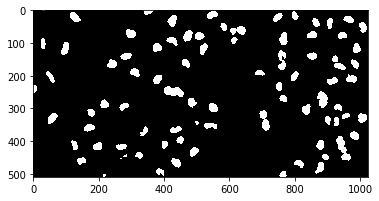

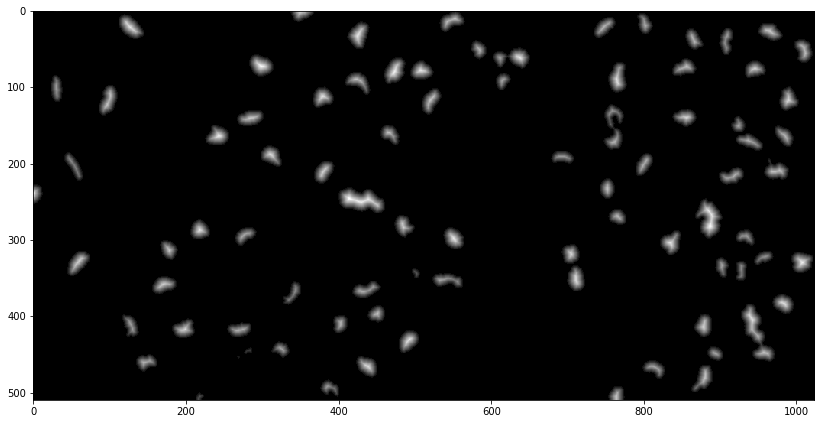

In [10]:
# Visualize the output.
plt.imshow(nmask, cmap="gray")
plt.figure(figsize=(14,14))
plt.imshow(dist_transf,interpolation='none',cmap='gray')
plt.show()

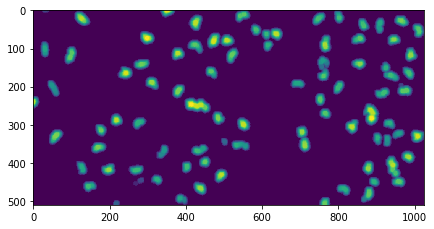

In [11]:
# Dilate the distance threshold
# Use ndi.filters.maximum_filter to dilate the distance transform.
i = 10
struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2
dist_trans_dil = ndi.filters.maximum_filter(dist_transf, footprint=struct) 
plt.figure(figsize=(7,7))
plt.imshow(dist_trans_dil, interpolation='none', cmap='viridis')
plt.show()

In [12]:
# Retrieve the local maxima (the 'peaks') in the distance transform
# Use the function peak_local_max from the module skimage.feature.
from skimage.feature import peak_local_max
seeds = peak_local_max(dist_trans_dil, indices=False, min_distance=10)

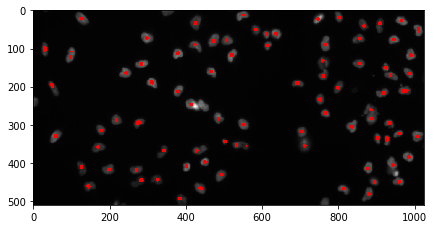

In [13]:
# Visualize the output
# you can first plot the original input (or the smoothed) image and
# then plot the seeds on top of it before showing both with 'plt.show'.
plt.figure(figsize=(7,7))
plt.imshow(smoothed_image, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds,mask=seeds==0),interpolation='none',cmap='autumn')
plt.show()

In [14]:
# Label the seeds
# Use connected component labeling to give each cell seed a unique ID number.
seeds_labeled = ndi.label(seeds)[0]

In [15]:
# Perform watershed
# Use the function watershed from the module skimage.morphology.
# Use the labeled nuclei seeds and the smoothed nuclei image as input.
from skimage.morphology import watershed
ws = watershed(smoothed_image,seeds_labeled)

/home/baecker/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


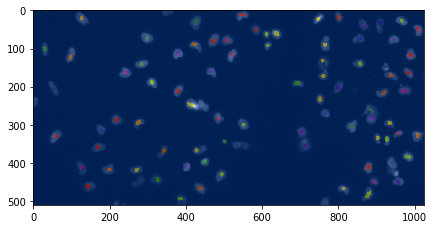

In [16]:
# Show the result as transparent overlay over the smoothed input image
plt.figure(figsize=(7,7))
plt.imshow(smoothed_image, interpolation='none', cmap='gray')
plt.imshow(ws,interpolation='none',cmap='prism',alpha=0.4)
plt.show()

# segmenting cells using Voronoi

Find boundaries between adjacent regions in an image, where seeds have been already identified in the individual regions to be segmented. The method finds the Voronoi region of each seed on a manifold with a metric controlled by local image properties. The method is motivated by the problem of finding the borders of cells in microscopy images, given a labelling of the nuclei in the images.

See 
Jones T.R., Carpenter A., Golland P. (2005) Voronoi-Based Segmentation of Cells on Image Manifolds. In: Liu Y., Jiang T., Zhang C. (eds) Computer Vision for Biomedical Image Applications. CVBIA 2005. Lecture Notes in Computer Science, vol 3765. Springer, Berlin, Heidelberg

## Exercises 5 - A modified voronoi algorithm

In [17]:
# The label function from skimage.measure module finds every connected set of pixels other than the background, 
# and relabels these sets with a unique increasing integer.
from skimage.measure import label
markers_nuc = label(nmask, connectivity=2, return_num=True)

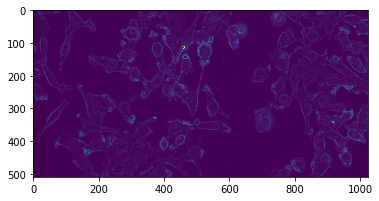

In [18]:
# We apply a sobel filter from skimage.filters to detect edges from cell body and serve as input 
# for the voronoi algorithm. 
from skimage.filters import sobel

fsobel = np.empty_like(mix_2)
fsobel = sobel(mix_2)

# Visualize the output
plt.imshow(fsobel)

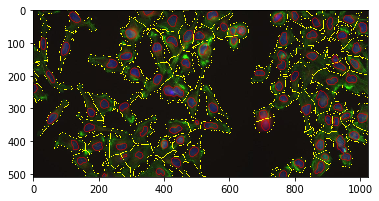

In [20]:
# This algo is implemented in the centrosome package, an open source image processing library.
from centrosome.propagate import propagate
cell_seg,_ = propagate(image=fsobel, labels=markers_nuc[0], mask=cmask, weight=1)

# Visualize the output. Focus on boundaries between labeled 
# regions highlighted thanks to mark_boundaries from skimage.segmentation and draw contour lines 
# for nuclei thanks to contour from matplotlib.pyplot.
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(composite, cell_seg))
plt.contour(nmask, colors = 'r', linewidths = 0.1)

## Exercises 6 - Quantification of cell features

The ultimate goal of image segmentation is of course the extraction of quantitative measurements, in this case on a single-cell level. Measures of interest can be based on intensity (in different channels) or on the size and shape of the cells.

we will extract the following:

    Cell ID (so all other measurements can be traced back to the cell that was measured)
    Mean intensity of each cell, for each channel
    The cell area i.e. the number of pixels that make up the cell

In [21]:
# Create a dictionary that contains a key-value pair for each measurement.
# The keys should be strings describing the type of measurement (e.g. 'cell_tubulin_mean') 
# and the values should be empty lists. These empty lists will be filled with the results of 
# the measurements and the dictionary will make it easy to work with this dat
results = {"cell_id":[],
           "cell_tubulin_mean":[],
           "cell_actin_mean":[],
           "cell_area":[]}

# Record the measurements for each cell
# Iterate over the segmented cells (np.unique).
# Inside the loop, create a mask for the current cell and use it to extract the measurements listed above. 
# Add them to the appropriate list in the dictionary using the list.append method.
# Hint: Remember that you can get out all the values within a masked area by indexing the image 
#       with the mask. For example, np.mean(image[cell_mask]) will return the mean of all the 
#       intensity values of 'image' that are masked by 'cell_mask'.

# Iterate over cell IDs
for cell_id in np.unique(cell_seg)[1:]:

    # Mask the current cell
    cell_mask = cell_seg==cell_id
    
    # Get the measurements
    # Note: the .item() method ensures that the resulting number is converted from a numpy number object
    #       (e.g. type np.float) to a native python number object (e.g. type float). For most purposes,
    #       this is irrelevant, but for saving data in a python object as we do later on, it is useful
    #       to use native python objects only.
    results["cell_id"].append(cell_id.item())
    results["cell_area"].append(np.sum(cell_mask).item())
    results["cell_tubulin_mean"].append(np.mean(tritc[cell_mask]).item())
    results["cell_actin_mean"].append(np.mean(fitc[cell_mask]).item())
    
# Print the results and check that they make sense
for key in results.keys(): print key, '\n', results[key], '\n'

cell_tubulin_mean 
[0.16020495303159693, 0.16306805074971165, 0.20652541799228322, 0.19015525056792604, 0.1617345354634235, 0.23707242335037612, 0.17205478771622648, 0.18275425218023847, 0.1581430448755481, 0.1511153000314169, 0.18652393176397764, 0.165356452299681, 0.3325958738564841, 0.22316224951519067, 0.21020805268672355, 0.16581280726001377, 0.20131641219428728, 0.19384564440975424, 0.1821445144443658, 0.22718572694303657, 0.30878669386829877, 0.1606181866686068, 0.15618080495356038, 0.17102356538945854, 0.18248806226575445, 0.2985502225430049, 0.1813574179006355, 0.16439924077513085, 0.19150482999618418, 0.1580020387359837, 0.16182547506898476, 0.21300766231038293, 0.22884443117348463, 0.16033234394675303, 0.17984370373231365, 0.164503333614651, 0.17478094743279593, 0.158278310212727, 0.21497340832106335, 0.21161626016260163, 0.18262036206068188, 0.1930133985093195, 0.17662505671889633, 0.20426551641504911, 0.18062835408742772, 0.17708377896613192, 0.18004444922393084, 0.1864293

# Writing output files

The final step of the pipeline shows how to write output of the pipeline to files.

Data can be saved to files in a human-readable format such as text files (e.g. to import into Excel), in a format readable for other programs such as tif-images (e.g. to view in Fiji).


## Exercises 7 - write a tab-separated file

In [24]:
#  Write a tab-separated text file of the results dict
# The most generic way of saving numerical results is a simple text file. It can be imported into 
# pretty much any other program.

# To write normal text files, open an empty file object in write mode ('w') using the 'with'-statement.
with open('cell_results.txt','w') as outfile:

    # Use the file_object.write(string) method to write strings to the file. First write the header of the
    # date (the result dict keys), separated by tabs ('\t'). It makes sense to first generate a complete
    # string with all the headers and then write this string to the file. Note that you will need to 
    # explicitly write 'newline' characters ('\n') at the end of the line to switch to the next line.
    sorted_keys = sorted(results.keys())
    header_string = '\t'.join(sorted_keys) + '\n'
    outfile.write(header_string)

    # After writing the headers, iterate over all the cells saved and write the data to the file by
    # creating strings similar to the header string.
    for index in range(len(results['cell_id'])):
        data_string = '\t'.join([str(results[key][index]) for key in sorted_keys]) + '\n'
        outfile.write(data_string)
        
# After writing the data, have a look at the output file in a text editor or in a spreadsheet
# program like Excel.

## Exercises 8 - write a tab-separated file to omero as attachment

In [28]:
# Import BlitzGateway from omero.gateway to access API
import sys
sys.path.append('../../OMERO.server/lib/python')
from omero.gateway import BlitzGateway

# The getpass() function prints a prompt then reads input from the user until they press return.
# The input is passed back as a string to the caller. For that import getpass from getpass.
from getpass import getpass

# Use raw_input function to print a prompt for username, host and port.
# Warning: For port parameter cast the string to integer.

# Fill the parameters of BlitzGateway function: Username, Password, Host and Port
# Use connect function to connect you to the omero server.
conn = BlitzGateway(
    raw_input("Username: "), getpass("OMERO Password: "),
    host=raw_input("Host: "), port=int(raw_input("Port: ")))
conn.connect()

dataset_id = 7
dataset = conn.getObject("Dataset", dataset_id)
# Specify a local file e.g. could be result of some analysis
file_to_upload = "./cell_results.txt"   # This file should already exist
namespace = "result_output"
print "\nCreating an OriginalFile and FileAnnotation"
file_ann = conn.createFileAnnfromLocalFile(
    file_to_upload, mimetype="text/plain", ns=namespace, desc=None)
print "Attaching FileAnnotation to Dataset: ", "File ID:", file_ann.getId(), \
    ",", file_ann.getFile().getName(), "Size:", file_ann.getFile().getSize()
dataset.linkAnnotation(file_ann)     # link it to dataset.

Username: d
OMERO Password: ········
Host: d
Port: d


ValueError: invalid literal for int() with base 10: 'd'